<a href="https://colab.research.google.com/github/noviaputri/cbir_model_flask/blob/main/Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Cloning dataset

In [1]:
!git clone https://github.com/noviaputri/dataset_image.git

Cloning into 'dataset_image'...
remote: Enumerating objects: 483, done.
remote: Counting objects: 100% (483/483), done.
remote: Compressing objects: 100% (481/481), done.
remote: Total 483 (delta 12), reused 472 (delta 1), pack-reused 0
Receiving objects: 100% (483/483), 27.13 MiB | 35.21 MiB/s, done.
Resolving deltas: 100% (12/12), done.


## Import Library

In [2]:
import numpy as np
import json
import os
import cv2
import copy
import sklearn.metrics as metric
import pandas as pd
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint 

from keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
from keras.applications.inception_v3 import InceptionV3,preprocess_input

import matplotlib.pyplot as plt
import matplotlib

from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import *

## Define parameter value and file path

In [3]:
EPOCHS = 50
INIT_LR = 1e-3
BS = 16
IMAGE_SIZE = (128, 128)
checkpoint_path = "model/training_3_subclass_cp/cp.ckpt"
feature_path = "model/training_3_subclass_feature.json"
model_path = "model/training_3_subclass_model.h5"
history_path = "model/training_3_subclass_history.json"
base_dataset = "dataset_image"
class_dir = ['Normal', 'Tube', 'Effusion']

## Load dataset for data train and data validation

In [4]:
print("[INFO] indexing file images Otomatch dataset...")
type_dataset = ['val', 'train']
dataset_train = []
dataset_val = []
for type_set in type_dataset:
    for class_item in class_dir:
        cur_dir = os.path.join(base_dataset, type_set, class_item)
        for file in os.listdir(cur_dir):
            if type_set == 'train':
                dataset_train.append(os.path.join(cur_dir, file))
            else:
                dataset_val.append(os.path.join(cur_dir, file))

print("[INFO] load images Otomatch dataset...")
# load images
train_images = []
val_images = []
for type_set in type_dataset:
    cur_dataset = dataset_train if type_set == 'train' else dataset_val
    for image_path in cur_dataset:
        if ".jpg" in image_path:
            image = cv2.imread(image_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, IMAGE_SIZE)
            if type_set == 'train':
                train_images.append(image)
            else:
                val_images.append(image)

[INFO] indexing file images Otomatch dataset...
[INFO] load images Otomatch dataset...


## Example image before and after preprocessing

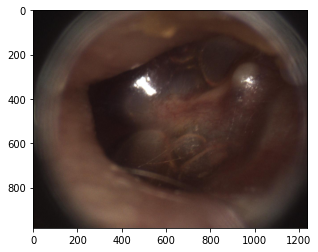

In [5]:
# show example image
img_ori = cv2.imread('dataset_image/train/Effusion/AM156L.jpg')
img_ori = cv2.cvtColor(img_ori, cv2.COLOR_BGR2RGB)
plt.imshow(img_ori)
#plt.show()

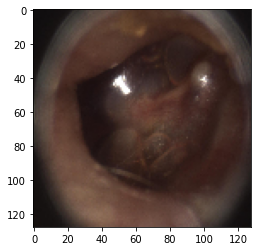

In [6]:
# show example image
img_preprocess = cv2.imread('dataset_image/train/Effusion/AM156L.jpg')
img_preprocess = cv2.cvtColor(img_preprocess, cv2.COLOR_BGR2RGB)
img_preprocess = cv2.resize(img_preprocess, (128, 128))
plt.imshow(img_preprocess)
#plt.show()

## Data normalization

In [7]:
# normalization
print("[INFO] normalization...")
train_x = np.array(train_images).astype("float32") / 255.0
val_x = np.array(val_images).astype("float32") / 255.0

[INFO] normalization...


## Augmentation layer

In [8]:
# augmentation layer
data_augmentation = tf.keras.Sequential([layers.RandomFlip("horizontal_and_vertical"),
                                         layers.RandomRotation(0.2),
                                         layers.RandomContrast(0.2),
                                         layers.RandomTranslation(0.3,0.3)])

## Make CNN Autoencoder Model

In [9]:
class ConvAutoEncoder:
    """
    Core Convolutional AutoEncoder
    This class included with build method you can adjust of width height and depth of image
    default filters 32, and latent dimension 16
    """
    @staticmethod
    def build(width, height, depth, filters=(32,), latent_dim=16):
        input_shape = (height, width, depth)
        channel_dim = -1
        inputs = layers.Input(shape=input_shape)
        x = inputs
        x = data_augmentation(x)
        # Encoder layer
        for f in filters:
            x = layers.Conv2D(f, (3, 3), strides=2, padding='same')(x)
            x = layers.LeakyReLU(alpha=0.2)(x)
            x = layers.BatchNormalization(axis=channel_dim, name='enc_filter_' + str(32))(x)
        volume_size = K.int_shape(x)
        x = layers.Flatten()(x)
        # Latent layer
        latent = layers.Dense(latent_dim, name="encoded")(x)
        # Decoder layer
        x = layers.Dense(np.prod(volume_size[1:]))(latent)
        x = layers.Reshape((volume_size[1], volume_size[2], volume_size[3]))(x)
        # Reverse on decoder
        for f in filters[::-1]:
            x = layers.Conv2DTranspose(f, (3, 3), strides=2, padding='same')(x)
            x = layers.LeakyReLU(alpha=0.2)(x)
            x = layers.BatchNormalization(axis=channel_dim, name='dec_filter_' + str(f))(x)
        x = layers.Conv2DTranspose(depth, (3, 3), padding="same")(x)
        outputs = layers.Activation("sigmoid", name="decoded")(x)
        auto_encoder = Model(inputs, outputs, name="auto_encoder")
        return auto_encoder

In [10]:
print("[INFO] building auto encoder...")
auto_encoder = ConvAutoEncoder.build(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)
opt = Adam(learning_rate=INIT_LR, decay=INIT_LR / EPOCHS)
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    monitor="val_loss",
    verbose = 1,
    mode='min',
    save_best_only=True)
auto_encoder.compile(loss="mse", optimizer=opt, metrics='accuracy')
auto_encoder.summary()

[INFO] building auto encoder...
Model: "auto_encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 128, 128, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 64, 64, 32)        0         
                                                                 
 enc_filter_32 (BatchNormali  (None, 64, 64, 32)       128       
 zation)                                                         
                                                                 
 flatten (Flatten)           (None, 131072)            0         
                      

## Train model

In [11]:
# train the convolutional auto encoder
print("[INFO] training auto encoder...")
H = auto_encoder.fit(
    train_x, train_x,
    shuffle=True,
    validation_data=(val_x, val_x),
    epochs=EPOCHS,
    callbacks = [checkpoint_callback], batch_size=BS)

[INFO] training auto encoder...
Epoch 1/50
18/18 [==============================] - ETA: 0s - loss: 0.0670 - accuracy: 0.4166
Epoch 00001: val_loss improved from inf to 0.09324, saving model to model/training_3_subclass_cp/cp.ckpt
18/18 [==============================] - 13s 610ms/step - loss: 0.0670 - accuracy: 0.4166 - val_loss: 0.0932 - val_accuracy: 0.5167
Epoch 2/50
18/18 [==============================] - ETA: 0s - loss: 0.0490 - accuracy: 0.5657
Epoch 00002: val_loss improved from 0.09324 to 0.05890, saving model to model/training_3_subclass_cp/cp.ckpt
18/18 [==============================] - 11s 592ms/step - loss: 0.0490 - accuracy: 0.5657 - val_loss: 0.0589 - val_accuracy: 0.7678
Epoch 3/50
18/18 [==============================] - ETA: 0s - loss: 0.0422 - accuracy: 0.6483
Epoch 00003: val_loss improved from 0.05890 to 0.05108, saving model to model/training_3_subclass_cp/cp.ckpt
18/18 [==============================] - 11s 605ms/step - loss: 0.0422 - accuracy: 0.6483 - val_los

In [12]:
with open(history_path, 'w') as f:
    json.dump(H.history, f)
auto_encoder.save(model_path)

## Evaluate Model

In [13]:
reconstruction_score = auto_encoder.evaluate(val_x, val_x, verbose=0)
print("Convolutional autoencoder score:", reconstruction_score)
print("Test Loss:", reconstruction_score[0])
print("Test Accuracy:", reconstruction_score[1])

Convolutional autoencoder score: [0.03398055210709572, 0.8809307217597961]
Test Loss: 0.03398055210709572
Test Accuracy: 0.8809307217597961


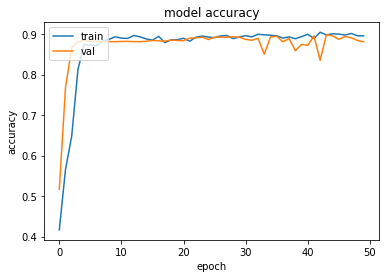

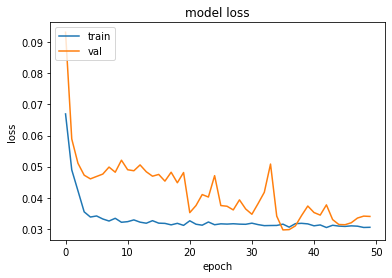

In [14]:
plt.plot(H.history['accuracy'])
plt.plot(H.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(H.history['loss'])
plt.plot(H.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Features extraction

In [15]:
auto_encoder = ConvAutoEncoder.build(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)
# load our auto_encoder from disk
print("[INFO] loading auto encoder model...")
auto_encoder.load_weights(checkpoint_path)

#auto_encoder.save('model/training_model.h5')
#auto_encoder.save_weights('model/weight_model.h5')

# create the encoder model which consists of *just* the encoder
# portion of the auto encoder
encoder = Model(inputs=auto_encoder.input, outputs=auto_encoder.get_layer("encoded").output)

# quantify the contents of our input images using the encoder
print("[INFO] encoding images...")
features = encoder.predict(train_x)

[INFO] loading auto encoder model...
[INFO] encoding images...


## Make json data to store index, label, and features 

In [16]:
indexes = list(range(0, train_x.shape[0]))
features_array = [[float(x) for x in y] for y in features]
labels = [path.split("/")[2] for path in dataset_train]
data = {"indexes": indexes, "features": features_array, "locations": dataset_train, "labels":labels}

In [17]:
with open(feature_path, 'w') as f:
    json.dump(data, f)

## Make function for similarity measure and perform search

In [18]:
def euclidean(a, b):
	# compute and return the euclidean distance between two vectors
	return np.linalg.norm(a - b)

In [19]:
def perform_search(query_features, indexed_train, max_results=5):
	retrieved = []
	for idx in range(0, len(indexed_train["features"])):
		distance = euclidean(query_features, indexed_train["features"][idx])
		retrieved.append((distance, idx))
	retrieved = sorted(retrieved)[:max_results]
	return retrieved

## Load data test and predict features

In [21]:
print("[INFO] indexing file images Otomatch dataset...")
# indexing file images
dataset = []
for class_item in class_dir:
    cur_dir = os.path.join(base_dataset, 'test', class_item)
    for file in os.listdir(cur_dir):
        dataset.append(os.path.join(cur_dir, file))
print("test len to retrieving:", len(dataset))
print("[INFO] load test images Otomatch dataset...")
#  load images
images = []
for image_path in dataset:
    if ".jpg" in image_path:
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, IMAGE_SIZE)
        images.append(image)

[INFO] indexing file images Otomatch dataset...
test len to retrieving: 46
[INFO] load test images Otomatch dataset...


In [22]:
# normalization
print("[INFO] normalization...")
test_x = np.array(images).astype("float32") / 255.0

[INFO] normalization...


In [23]:
auto_encoder = ConvAutoEncoder.build(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)
# load our auto_encoder from disk
print("[INFO] loading auto encoder model...")
auto_encoder.load_weights(checkpoint_path)
with open(feature_path) as f:
  training_indexed = json.load(f)

# create the encoder model which consists of *just* the encoder
# portion of the auto encoder
encoder = Model(inputs=auto_encoder.input,
	outputs=auto_encoder.get_layer("encoded").output)

# quantify the contents of our input images using the encoder
print("[INFO] encoding images...")
features_retrieved = encoder.predict(test_x)

[INFO] loading auto encoder model...
[INFO] encoding images...


## Calculate recall, precision, and accuracy value

In [24]:
query_indexes = list(range(0, test_x.shape[0]))
label_builder = list(np.unique(training_indexed["labels"]))
class_builder = {label_unique:[] for label_unique in label_builder}
recalls = copy.deepcopy(class_builder)
precisions = copy.deepcopy(class_builder)
accuracies = copy.deepcopy(class_builder)
# loop over the testing indexes
for i in query_indexes:
    queryFeatures = features_retrieved[i]
    results = perform_search(queryFeatures, training_indexed, max_results=5)
    labels_ret = [training_indexed["labels"][r[1]] for r in results]
    label_true = dataset[i].split("/")[2]
    label_trues = [label_true for _ in labels_ret]
    recall = metric.recall_score(label_trues, labels_ret, average='weighted')
    precision = metric.precision_score(label_trues, labels_ret, average='weighted')
    accuracy = metric.accuracy_score(label_trues, labels_ret)
    recalls[label_true].append(recall)
    precisions[label_true].append(precision)
    accuracies[label_true].append(accuracy)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and 

In [25]:
print("recall values:")
comb_recall, comb_precision = [], []
for key in recalls.keys():
    average_val = np.average(recalls[key])
    print(key, average_val)
    comb_recall.append(average_val)
print("combined recall", np.average(comb_recall))

print("\nprecision values:")
for key in precisions.keys():
    average_val = np.average(precisions[key])
    print(key, average_val)
    comb_precision.append(average_val)
print("combined precision", np.average(comb_precision))

print("\naccuracy values:")
comb_accuracy = []
for key in accuracies.keys():
    average_val = np.average(accuracies[key])
    print(key, average_val)
    comb_accuracy.append(average_val)
print("combined accuracy", np.average(comb_accuracy))

recall values:
Effusion 0.4111111111111111
Normal 0.7555555555555556
Tube 0.27999999999999997
combined recall 0.4822222222222223

precision values:
Effusion 0.8333333333333334
Normal 1.0
Tube 0.5
combined precision 0.7777777777777778

accuracy values:
Effusion 0.4111111111111111
Normal 0.7555555555555556
Tube 0.27999999999999997
combined accuracy 0.4822222222222223


## Perform Retrieved Image

In [26]:
def build_montages(image_list, image_shape, montage_shape):
    if len(image_shape) != 2:
        raise Exception('image shape must be list or tuple of length 2 (rows, cols)')
    if len(montage_shape) != 2:
        raise Exception('montage shape must be list or tuple of length 2 (rows, cols)')
    image_montages = []
    # start with black canvas to draw images onto
    montage_image = np.zeros(shape=(image_shape[1] * (montage_shape[1]), image_shape[0] * montage_shape[0], 3),
                          dtype=np.uint8)
    cursor_pos = [0, 0]
    start_new_img = False
    for img in image_list:
        if type(img).__module__ != np.__name__:
            raise Exception('input of type {} is not a valid numpy array'.format(type(img)))
        start_new_img = False
        img = cv2.resize(img, image_shape)
        # draw image to black canvas
        montage_image[cursor_pos[1]:cursor_pos[1] + image_shape[1], cursor_pos[0]:cursor_pos[0] + image_shape[0]] = img
        cursor_pos[0] += image_shape[0]  # increment cursor x position
        if cursor_pos[0] >= montage_shape[0] * image_shape[0]:
            cursor_pos[1] += image_shape[1]  # increment cursor y position
            cursor_pos[0] = 0
            if cursor_pos[1] >= montage_shape[1] * image_shape[1]:
                cursor_pos = [0, 0]
                image_montages.append(montage_image)
                # reset black canvas
                montage_image = np.zeros(shape=(image_shape[1] * (montage_shape[1]), image_shape[0] * montage_shape[0], 3),
                                      dtype=np.uint8)
                start_new_img = True
    if start_new_img is False:
        image_montages.append(montage_image)  # add unfinished montage
    return image_montages

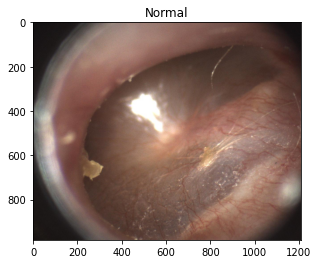

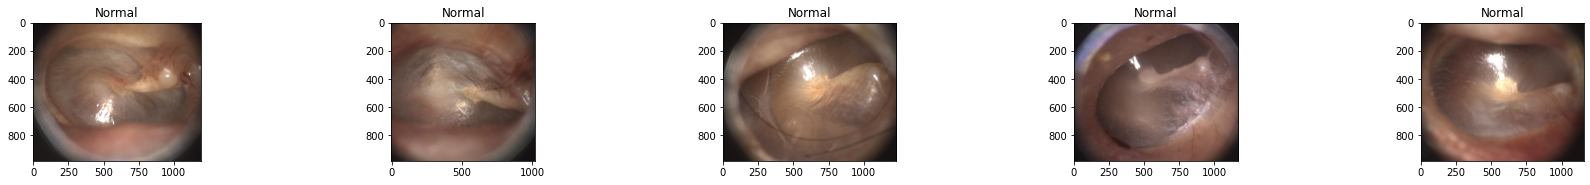

In [27]:
from PIL import Image

queryIdx = 2 # Input Index for which images 

queryFeatures = features_retrieved[queryIdx]
results = perform_search(queryFeatures, training_indexed, max_results=5)

imgs = []
result_path = []

# loop over the results
for (d, j) in results:
    img = np.array(Image.open(dataset_train[j]))
    result_path.append(dataset_train[j])
    imgs.append(img)

# display the query image
plt.title(dataset[queryIdx].split("/")[2])
plt.imshow(np.array(Image.open(dataset[queryIdx])))

plt.figure(figsize=(30,30))
columns = 5
for i, image in enumerate(imgs):
    plt.subplot(len(images) / columns + 1, columns, i + 1)
    result_label = result_path[i].split("/")[2]
    plt.title(result_label)
    plt.imshow(image)

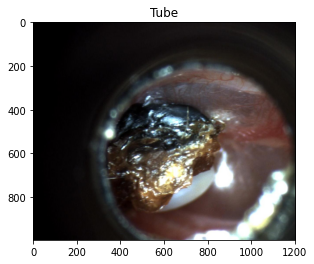

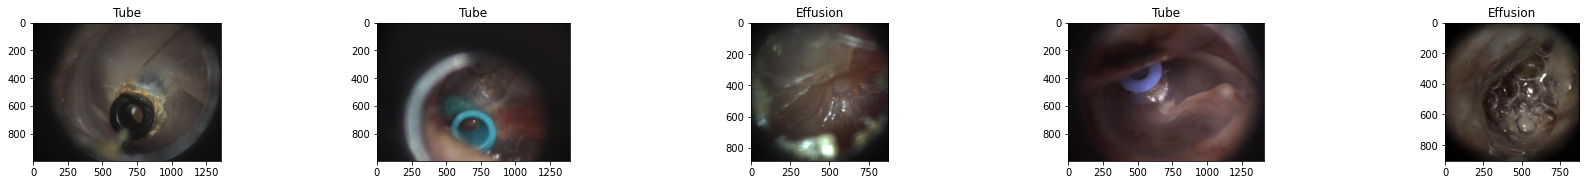

In [28]:
queryIdx = 18 # Input Index for which images 

queryFeatures = features_retrieved[queryIdx]
results = perform_search(queryFeatures, training_indexed, max_results=5)

imgs = []
result_path = []

# loop over the results
for (d, j) in results:
    img = np.array(Image.open(dataset_train[j]))
    result_path.append(dataset_train[j])
    imgs.append(img)

# display the query image
plt.title(dataset[queryIdx].split("/")[2])
plt.imshow(np.array(Image.open(dataset[queryIdx])))

plt.figure(figsize=(30,30))
columns = 5
for i, image in enumerate(imgs):
    plt.subplot(len(images) / columns + 1, columns, i + 1)
    result_label = result_path[i].split("/")[2]
    plt.title(result_label)
    plt.imshow(image)

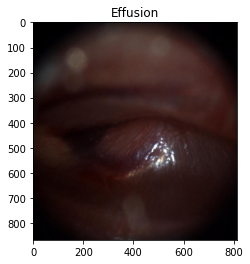

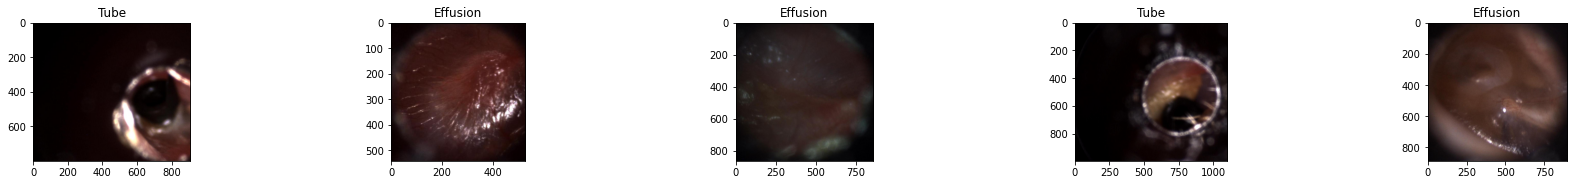

In [29]:
queryIdx = 43 # Input Index for which images 

queryFeatures = features_retrieved[queryIdx]
results = perform_search(queryFeatures, training_indexed, max_results=5)

imgs = []
result_path = []

# loop over the results
for (d, j) in results:
    img = np.array(Image.open(dataset_train[j]))
    result_path.append(dataset_train[j])
    imgs.append(img)

# display the query image
plt.title(dataset[queryIdx].split("/")[2])
plt.imshow(np.array(Image.open(dataset[queryIdx])))

plt.figure(figsize=(30,30))
columns = 5
for i, image in enumerate(imgs):
    plt.subplot(len(images) / columns + 1, columns, i + 1)
    result_label = result_path[i].split("/")[2]
    plt.title(result_label)
    plt.imshow(image)

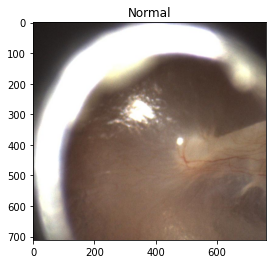

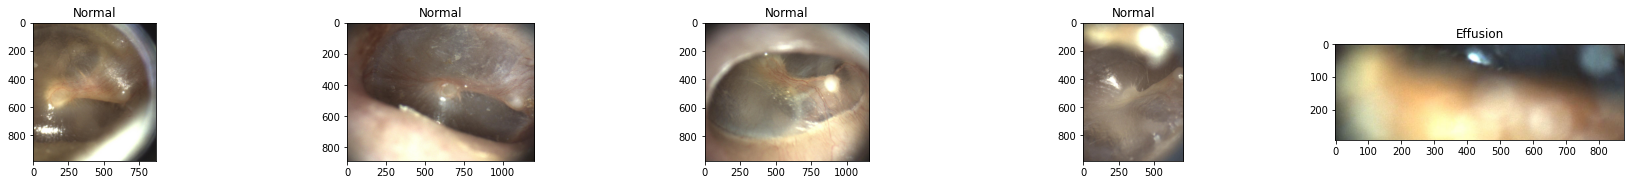

In [30]:
queryIdx = 10 # Input Index for which images 

queryFeatures = features_retrieved[queryIdx]
results = perform_search(queryFeatures, training_indexed, max_results=5)

imgs = []
result_path = []

# loop over the results
for (d, j) in results:
    img = np.array(Image.open(dataset_train[j]))
    result_path.append(dataset_train[j])
    imgs.append(img)

# display the query image
plt.title(dataset[queryIdx].split("/")[2])
plt.imshow(np.array(Image.open(dataset[queryIdx])))

plt.figure(figsize=(30,30))
columns = 5
for i, image in enumerate(imgs):
    plt.subplot(len(images) / columns + 1, columns, i + 1)
    result_label = result_path[i].split("/")[2]
    plt.title(result_label)
    plt.imshow(image)

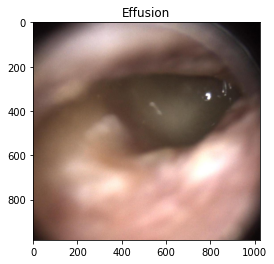

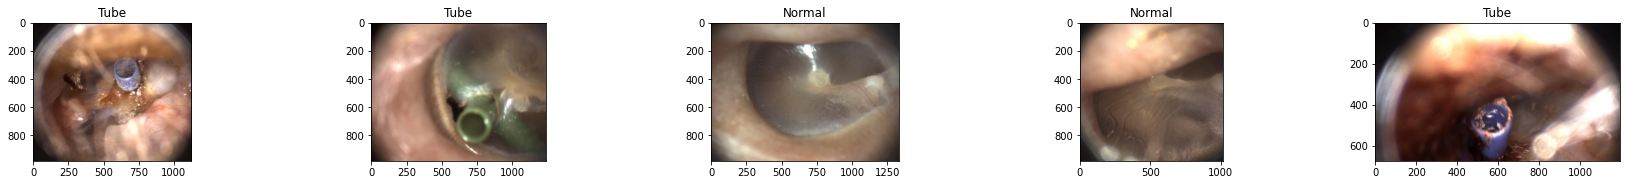

In [31]:
queryIdx = 28 # Input Index for which images 

queryFeatures = features_retrieved[queryIdx]
results = perform_search(queryFeatures, training_indexed, max_results=5)

imgs = []
result_path = []

# loop over the results
for (d, j) in results:
    img = np.array(Image.open(dataset_train[j]))
    result_path.append(dataset_train[j])
    imgs.append(img)

# display the query image
plt.title(dataset[queryIdx].split("/")[2])
plt.imshow(np.array(Image.open(dataset[queryIdx])))

plt.figure(figsize=(30,30))
columns = 5
for i, image in enumerate(imgs):
    plt.subplot(len(images) / columns + 1, columns, i + 1)
    result_label = result_path[i].split("/")[2]
    plt.title(result_label)
    plt.imshow(image)